In [1]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")

import numpy as np
import matplotlib.pyplot as plt
import operator

from sklearn import svm
from scipy import io
from skimage import color

from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
from skimage.feature import hog

import pandas as pd

## 1 (a)

In [2]:
!python --version

Python 3.6.6


## 1 (b)

In [3]:
!pip install scikit-learn scipy numpy matplotlib

## 1 (c)

In [2]:
data = []
data_name = ["mnist", "spam", "cifar10"]
for name in data_name:
    data.append(io.loadmat("data/%s_data.mat" % name))
    print("\nloaded %s data!" % name)
    fields = "test_data", "training_data", "training_labels"
    
print()

for i in range(3):
    print(data_name[i])
    for field in fields:
        print(field, data[i][field].shape)
    print()


loaded mnist data!

loaded spam data!

loaded cifar10 data!

mnist
test_data (10000, 784)
training_data (60000, 784)
training_labels (60000, 1)

spam
test_data (5857, 32)
training_data (5172, 32)
training_labels (5172, 1)

cifar10
test_data (10000, 3072)
training_data (50000, 3072)
training_labels (50000, 1)



In [3]:
mnist = data[0]
spam = data[1]
cifar10 = data[2]

In [4]:
mnist_train = mnist['training_data']/255
mnist_label = mnist['training_labels']
mnist_test = mnist['test_data']/255

spam_train = spam['training_data']
spam_label = spam['training_labels']
spam_test = spam['test_data']

cifar10_train = cifar10['training_data']
cifar10_label = cifar10['training_labels']
cifar10_test = cifar10['test_data']

In [5]:
mnist_data = np.append(mnist_train, mnist_label, axis=1)
spam_data = np.append(spam_train, spam_label, axis=1)
cifar10_data = np.append(cifar10_train, cifar10_label, axis=1)

In [9]:
def split(data, size):
    from math import floor
    
    dat = data.copy()
    
    # for reproducibility
    np.random.seed(24)
    
    # shuffle copied data
    np.random.shuffle(dat)
    
    if type(size) == float:
        size = floor(len(dat) * size)

    # training_data, validation_data, training_label, validation_label
    return dat[size:, :-1], dat[:size, :-1], dat[size:, -1], dat[:size, -1]


## 2 (a) 

In [10]:
X_mnist_train, X_mnist_valid, y_mnist_train, y_mnist_valid = split(mnist_data, 10000)

## 2 (b) 

In [11]:
X_spam_train, X_spam_valid, y_spam_train, y_spam_valid = split(spam_data, 0.2)

## 2 (c)

In [12]:
X_cifar10_train, X_cifar10_valid, y_cifar10_train, y_cifar10_valid = split(cifar10_data, 5000)

In [13]:
X_mnist_train.shape, X_spam_train.shape, X_cifar10_train.shape

((50000, 784), (4138, 32), (45000, 3072))

In [14]:
X_mnist_valid.shape, X_spam_valid.shape, X_cifar10_valid.shape

((10000, 784), (1034, 32), (5000, 3072))

In [15]:
len(mnist_data), len(spam_data), len(cifar10_data)

(60000, 5172, 50000)

## 3 (a) 

In [15]:
mnist_size = [100, 200, 500, 1000, 2000, 5000, 10000]
valid_accuracy = []
train_accuracy = []

for size in mnist_size:

    train = X_mnist_train[:size]
    label = y_mnist_train[:size]
    
    model = svm.SVC(kernel='linear')
    
    model.fit(train, label)
    
    pred = model.predict(X_mnist_valid)
    
    valid_accuracy.append(1-accuracy_score(y_mnist_valid, pred))
    train_accuracy.append(1-accuracy_score(label, model.predict(train)))

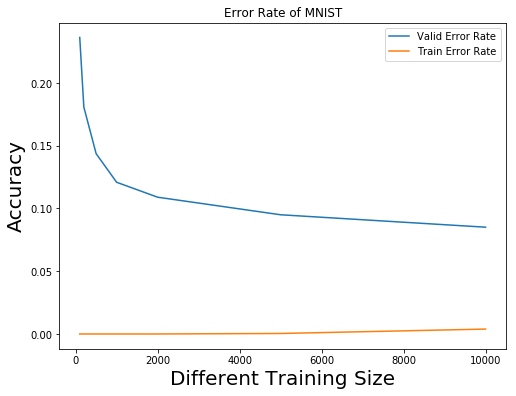

In [16]:
plt.figure(figsize=(8,6))

plt.plot(mnist_size, valid_accuracy, label='Valid Error Rate')
plt.plot(mnist_size, train_accuracy, label='Train Error Rate')

plt.xlabel('Different Training Size',size=20)
plt.ylabel('Accuracy',size=20)
plt.legend()
plt.title("Error Rate of MNIST")
plt.show();

## 3 (b)

In [17]:
spam_size = [100, 200, 500, 1000, 2000, len(spam_data)]
valid_accuracy = []
train_accuracy = []

for size in spam_size:
    
    train = X_spam_train[:size]
    label = y_spam_train[:size]
    
    model = svm.SVC(kernel='linear')
    
    model.fit(train, label)
    
    pred = model.predict(X_spam_valid)

    valid_accuracy.append(1-accuracy_score(y_spam_valid, pred))
    train_accuracy.append(1-accuracy_score(label, model.predict(train)))

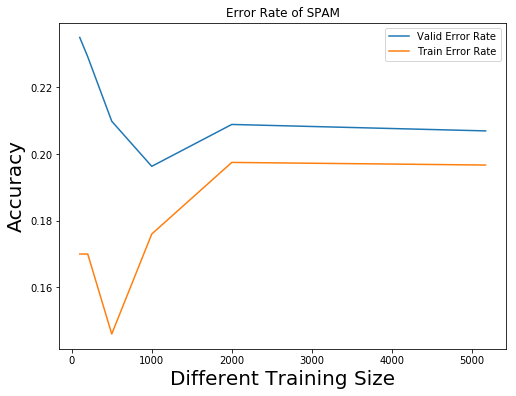

In [18]:
plt.figure(figsize=(8,6))

plt.plot(spam_size, valid_accuracy, label='Valid Error Rate')
plt.plot(spam_size, train_accuracy, label='Train Error Rate')

plt.xlabel('Different Training Size',size=20)
plt.ylabel('Accuracy',size=20)
plt.legend()
plt.title("Error Rate of SPAM")
plt.show();

## 3 (c) 

In [17]:
cifar10_size = [100, 200, 500, 1000, 2000, 5000]
valid_accuracy = []
train_accuracy = []

for size in cifar10_size:
    
    train = X_cifar10_train[:size]
    label = y_cifar10_train[:size]
    
    model = svm.SVC(kernel='linear')
    
    model.fit(train, label)
    
    pred = model.predict(X_cifar10_valid)
    
    valid_accuracy.append(1-accuracy_score(y_cifar10_valid, pred))
    train_accuracy.append(1-accuracy_score(label, model.predict(train)))

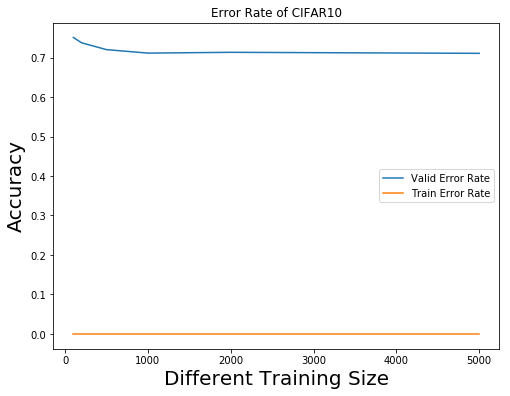

In [18]:
plt.figure(figsize=(8,6))

plt.plot(cifar10_size, valid_accuracy, label='Valid Error Rate')
plt.plot(cifar10_size, train_accuracy, label='Train Error Rate')

plt.xlabel('Different Training Size',size=20)
plt.ylabel('Accuracy',size=20)
plt.title("Error Rate of CIFAR10")
plt.legend()
plt.show();

## 4

In [19]:
C = np.arange(1, 60, 10)
SIZE = [100, 500, 1000, 2000, 5000]
accuracy = []
max_c = [0,0,0]

for c in C:
    for size in SIZE:
        model = svm.SVC(c, kernel='linear')
        
        train = X_mnist_train[:size]
        label = y_mnist_train[:size]
        
        model.fit(train, label)
        
        accuracy.append([c, size, accuracy_score(y_mnist_valid, model.predict(X_mnist_valid))])
        
        if accuracy[-1][2] > max_c[2]:
            max_c = accuracy[-1]

In [20]:
print('C value : {}\nTrain Size : {}\nAccuracy : {}'.format(max_c[0], max_c[1], max_c[2]))

C value : 1
Train Size : 5000
Accuracy : 0.905


In [21]:
print('C value tested from 1 to 50')

C value tested from 1 to 50


In [22]:
# C value, Training Size, Accuracy
accuracy

[[1, 100, 0.7637],
 [1, 500, 0.8563],
 [1, 1000, 0.8791],
 [1, 2000, 0.891],
 [1, 5000, 0.905],
 [11, 100, 0.7637],
 [11, 500, 0.8563],
 [11, 1000, 0.8791],
 [11, 2000, 0.891],
 [11, 5000, 0.9042],
 [21, 100, 0.7637],
 [21, 500, 0.8563],
 [21, 1000, 0.8791],
 [21, 2000, 0.891],
 [21, 5000, 0.9042],
 [31, 100, 0.7637],
 [31, 500, 0.8563],
 [31, 1000, 0.8791],
 [31, 2000, 0.891],
 [31, 5000, 0.9042],
 [41, 100, 0.7637],
 [41, 500, 0.8563],
 [41, 1000, 0.8791],
 [41, 2000, 0.891],
 [41, 5000, 0.9042],
 [51, 100, 0.7637],
 [51, 500, 0.8563],
 [51, 1000, 0.8791],
 [51, 2000, 0.891],
 [51, 5000, 0.9042]]

## 5

In [23]:
def K_fold(data, k, c):
    
    size = int(len(data) / k)
    dat = data.copy()
    np.random.shuffle(dat)
    
    accuracy = []
    
    
    for i in range(k):
        index = np.arange(len(dat))
        
        if i <= k-1:
            valid_ind = index[i*size : (1+i)*size]
        else:
            valid_ind = index[(1+i)*size:]
            
        train_ind = index[np.isin(index, valid_ind, invert=True)]

        valid = dat[valid_ind]
        train = dat[train_ind]
        
        X_train, y_train = train[:, :-1], train[:, -1]
        X_valid, y_valid = valid[:, :-1], valid[:, -1]

        model = svm.LinearSVC(C=c)
        model.fit(X_train, y_train)
        
        accuracy.append(accuracy_score(y_valid, model.predict(X_valid)))
    
    return np.mean(accuracy)

In [24]:
C = np.arange(1, 300, 1)
accuracy = {}

for c in C:
    accuracy[c] = K_fold(spam_data, 5, c)

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: C

In [25]:
max_c = max(accuracy.items(), key=operator.itemgetter(1))

In [26]:
print('C value : {}\nAccuracy : {}'.format(max_c[0], max_c[1]))

C value : 238
Accuracy : 0.8239845261121858


In [27]:
print('C value tested from 1 to 299')

C value tested from 1 to 299


## 6 Kaggle Submission

### Kaggle Name : Han Song

#### MNIST score : 0.98233

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(mnist_data[:,:-1], mnist_data[:,-1])

In [ ]:
model = svm.SVC(C=5, gamma=0.05)
model.fit(X_train, y_train)

pred = model.predict(mnist_test)

In [ ]:
accuracy_score(y_valid, model.predict(X_valid))

In [12]:
dat = pd.DataFrame(pred,columns=['Category'], index=np.arange(1, 10001, 1), dtype=int)
dat.index.name = 'Id'

dat.to_csv('mnist.csv')

#### SPAM score : 0.76949

In [13]:
from sklearn.feature_extraction.text import TfidfTransformer

In [27]:
transformer = TfidfTransformer()

In [28]:
tfidf = transformer.fit_transform(spam_data[:, :-1])

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(tfidf.toarray(), spam_data[:,-1])

In [55]:
test = transformer.fit_transform(spam_test)

In [56]:
model = svm.SVC(C=117, gamma=.06)
model.fit(X_train, y_train)

pred = model.predict(test.toarray())
acc = accuracy_score(y_valid, model.predict(X_valid))

In [59]:
dat = pd.DataFrame(pred,columns=['Category'], index=np.arange(1, len(test.toarray())+1, 1), dtype=int)
dat.index.name = 'Id'

dat.to_csv('spam.csv')

#### CIFAR10 score : .25533

#### Source from https://www.kaggle.com/manikg/training-svm-classifier-with-hog-features

In [28]:
cifar_train = cifar10_data[:, :-1].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
cifar_test = cifar10_test.reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)

labels = cifar10_data[:,-1].reshape(-1, 1)

data_gray = [ color.rgb2gray(i)/255 for i in cifar_train]
test_gray = [ color.rgb2gray(i)/255 for i in cifar_test]

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from int64 to float64
  .format(dtypeobj_in, dtypeobj_out))


In [29]:
ppc = 8
hog_images_train = []
hog_features_train = []

for image in data_gray:
    
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(3, 3),block_norm='L2',visualise=True)
    hog_images_train.append(hog_image)
    hog_features_train.append(fd)

    
hog_images_test = []
hog_features_test = []

for image in test_gray:
    
    fd,hog_image = hog(image, orientations=9, pixels_per_cell=(ppc,ppc),cells_per_block=(3, 3),block_norm='L2',visualise=True)
    hog_images_test.append(hog_image)
    hog_features_test.append(fd)

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/skimage/feature/_hog.py:248: skimage_deprecation: Argument `visualise` is deprecated and will be changed to `visualize` in v0.16
  'be changed to `visualize` in v0.16', skimage_deprecation)


In [31]:
hog_images_train = np.array(hog_images_train)
hog_images_test = np.array(hog_images_test)

In [32]:
data_frame_train = np.hstack((hog_images_train.reshape(-1, 32*32), hog_features_train))
dat_train = np.hstack((data_frame_train, cifar10_data[:, :-1]))

data_frame_test = np.hstack((hog_images_test.reshape(-1, 32*32), hog_features_test))
dat_test = np.hstack((data_frame_test, cifar10_test))

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(dat_train, labels)

In [41]:
clf = svm.SVC()

clf.fit(X_train[:5000], y_train[:5000])

pred = clf.predict(X_valid)

accuracy_score(y_valid, pred)

/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/hsong1101/miniconda3/envs/gluon/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.23232

In [34]:
pred = clf.predict(dat_test)

In [35]:
dat = pd.DataFrame(pred,columns=['Category'], index=np.arange(1, len(dat_test)+1, 1), dtype=int)
dat.index.name = 'Id'

dat.to_csv('cifar.csv')